# 🌊🏜️ Natural Disaster Prediction Model Training

## Big Data and Deep Learning-Based Natural Disaster Prediction Using Multi-Source Environmental Data

This notebook trains a multi-encoder deep learning model for predicting floods and droughts.

### Architecture Overview:
- **CNN Encoder**: Processes satellite features (NDVI, EVI, LST) - spatial patterns
- **LSTM Encoder**: Processes weather sequences (temp, precipitation, wind, etc.) - temporal patterns
- **MLP Encoder**: Processes static features (elevation, landcover, coordinates) - geographic context
- **Mid-Level Fusion**: Combines all encoder outputs
- **Prediction Heads**: Flood (binary) and Drought (multi-class) classification

## 1. Setup and Imports

In [1]:
# Standard libraries
import os
import sys
import time
import warnings
from datetime import datetime

# Data processing
import numpy as np
import pandas as pd

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Add project root to path - FIX for notebook
if 'notebooks' in os.getcwd():
    PROJECT_ROOT = os.path.dirname(os.getcwd())
else:
    PROJECT_ROOT = os.getcwd()

# Ensure project root is in path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Change to project root for consistent paths
os.chdir(PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")
print(f"Current working directory: {os.getcwd()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if hasattr(torch.backends, 'mps'):
    print(f"MPS available: {torch.backends.mps.is_available()}")

Project root: /Users/leonnn/Desktop/DL for disaster
Current working directory: /Users/leonnn/Desktop/DL for disaster
PyTorch version: 2.10.0
CUDA available: False
MPS available: True


In [2]:
# Import project modules
from configs.config import (
    get_config, get_fast_config, DATA_PATH, MODEL_DIR, LOG_DIR,
    SATELLITE_FEATURES, WEATHER_FEATURES, STATIC_FEATURES
)
from src.dataset import (
    DisasterDataProcessor, DisasterDataset, 
    create_dataloaders, compute_class_weights
)
from src.models import (
    DisasterPredictionModel, MultiTaskLoss, create_model
)
from src.utils import (
    setup_logger, MetricsCalculator, EarlyStopping,
    CheckpointManager, TrainingHistory, set_seed, get_device,
    format_time, plot_confusion_matrix
)

print("\n✅ All modules imported successfully!")


✅ All modules imported successfully!


## 2. Configuration

### ⚡ Chọn chế độ Training:
- **FAST_MODE = True**: ~30-60 phút (30 epochs, model nhỏ) - Để test nhanh
- **FAST_MODE = False**: ~3-5 giờ (100 epochs, full model) - Kết quả tốt nhất

In [3]:
# ========================================
# ⚡ CHỌN CHẾ ĐỘ TRAINING Ở ĐÂY
# ========================================
FAST_MODE = True   # True = nhanh (~1 giờ), False = đầy đủ (~3-5 giờ)
SAMPLE_DATA = 0.3  # Chỉ dùng 30% data (đặt 1.0 để dùng hết)
# ========================================

# Load configuration based on mode
config = get_fast_config() if FAST_MODE else get_config()

# Set random seed for reproducibility
set_seed(config.data.random_seed)

# Get device
device = get_device()
config.device = str(device)

# Print configuration summary
print("="*60)
print(f"{'⚡ FAST MODE' if FAST_MODE else '🔥 FULL MODE'} CONFIGURATION")
print("="*60)
print(f"\n📊 Data Configuration:")
print(f"   Data sampling: {SAMPLE_DATA*100:.0f}% of data")
print(f"   Batch size: {config.data.batch_size}")
print(f"   Sequence length: {config.data.sequence_length} days")

print(f"\n🏗️ Model Configuration:")
print(f"   Encoder output dim: {config.model.encoder_output_dim}")
print(f"   CNN channels: {config.model.cnn_channels}")
print(f"   LSTM hidden: {config.model.lstm_hidden_size}, layers: {config.model.lstm_num_layers}")

print(f"\n🎯 Training Configuration:")
print(f"   Epochs: {config.training.num_epochs}")
print(f"   Learning rate: {config.training.learning_rate}")
print(f"   Early stopping patience: {config.training.early_stopping_patience}")
print(f"   Device: {device}")
print(f"\n⏱️ Estimated time: {'~30-60 min' if FAST_MODE else '~3-5 hours'}")
print("="*60)

Random seed set to 42
Using Apple Silicon MPS
⚡ FAST MODE CONFIGURATION

📊 Data Configuration:
   Data sampling: 30% of data
   Batch size: 512
   Sequence length: 7 days

🏗️ Model Configuration:
   Encoder output dim: 64
   CNN channels: [16, 32, 64]
   LSTM hidden: 64, layers: 1

🎯 Training Configuration:
   Epochs: 30
   Learning rate: 0.001
   Early stopping patience: 5
   Device: mps

⏱️ Estimated time: ~30-60 min


## 3. Load and Preprocess Data

In [4]:
# Initialize data processor
processor = DisasterDataProcessor(config.data)

# Process data (load, handle missing values, normalize, split)
print("Loading and preprocessing data...")
train_df, val_df, test_df = processor.process(DATA_PATH)

# ===== SAMPLE DATA FOR FASTER TRAINING =====
if SAMPLE_DATA < 1.0:
    print(f"\n⚡ Sampling {SAMPLE_DATA*100:.0f}% of data for faster training...")
    train_df = train_df.sample(frac=SAMPLE_DATA, random_state=42).reset_index(drop=True)
    val_df = val_df.sample(frac=SAMPLE_DATA, random_state=42).reset_index(drop=True)
    # Keep full test set for accurate evaluation
    print(f"   Sampled train: {len(train_df):,}")
    print(f"   Sampled val: {len(val_df):,}")

# Save preprocessors for inference
processor.save_preprocessors()

print(f"\n✅ Data ready!")
print(f"   Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

Loading and preprocessing data...
Loading data from /Users/leonnn/Desktop/DL for disaster/SEA_2024_FINAL_CLEAN.csv...
Loaded 1,323,822 rows with 21 columns

Data splits:
  Train: 926,346 samples (70.0%)
  Valid: 198,738 samples (15.0%)
  Test:  198,738 samples (15.0%)
Filled 2,227 missing values in 'ndvi' with 0.6749
Filled 2,227 missing values in 'evi' with 0.4121
Filled 544,641 missing values in 'lst' with 27.3900
Filled 16,836 missing values in 'precip_mm' with 2.1642
Filled 16,836 missing values in 'temp_c' with 25.0372
Filled 16,836 missing values in 'dewpoint_c' with 20.9961
Filled 16,836 missing values in 'wind_u' with -0.1192
Filled 16,836 missing values in 'wind_v' with 0.2172
Filled 16,836 missing values in 'evap_mm' with 2.9369
Filled 20,273 missing values in 'pressure_hpa' with 978.2073
Filled 16,836 missing values in 'soil_temp_c' with 25.7139
Filled 720 missing values in 'ndvi' with 0.6749
Filled 720 missing values in 'evi' with 0.4121
Filled 117,325 missing values in 'ls

In [5]:
# Compute class weights for imbalanced data
class_weights = compute_class_weights(train_df)

# Move weights to device
flood_weights = class_weights['flood'].to(device)
drought_weights = class_weights['drought'].to(device)

print(f"\n📊 Data Distribution:")
print(f"   Training samples: {len(train_df):,}")
print(f"   Validation samples: {len(val_df):,}")
print(f"   Test samples: {len(test_df):,}")

print(f"\n   Flood distribution (train):")
print(train_df['flood'].value_counts())
print(f"\n   Drought distribution (train):")
print(train_df['drought'].value_counts())

Class weights computed:
  Flood: [0.526880145072937, 9.800536155700684]
  Drought: [0.5106914639472961, 23.883121490478516]

📊 Data Distribution:
   Training samples: 277,904
   Validation samples: 59,621
   Test samples: 198,738

   Flood distribution (train):
flood
0    263726
1     14178
Name: count, dtype: int64

   Drought distribution (train):
drought
0    272086
1      5818
Name: count, dtype: int64


## 4. Create DataLoaders

In [6]:
# Create dataloaders
print("Creating DataLoaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_df, val_df, test_df, config.data
)

print(f"\n✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader):,}")
print(f"   Val batches: {len(val_loader):,}")
print(f"   Test batches: {len(test_loader):,}")

Creating DataLoaders...
Created 262,718 valid samples
Created 56,363 valid samples
Created 195,480 valid samples

✅ DataLoaders created:
   Train batches: 514
   Val batches: 111
   Test batches: 382


In [7]:
# Verify batch shapes
sample_batch = next(iter(train_loader))

print("📦 Sample batch shapes:")
print(f"   Satellite (CNN input): {sample_batch['satellite'].shape}")
print(f"   Weather (LSTM input): {sample_batch['weather'].shape}")
print(f"   Static (MLP input): {sample_batch['static'].shape}")
print(f"   Flood labels: {sample_batch['flood_label'].shape}")
print(f"   Drought labels: {sample_batch['drought_label'].shape}")

📦 Sample batch shapes:
   Satellite (CNN input): torch.Size([512, 3, 5, 5])
   Weather (LSTM input): torch.Size([512, 7, 8])
   Static (MLP input): torch.Size([512, 4])
   Flood labels: torch.Size([512])
   Drought labels: torch.Size([512])


## 5. Initialize Model

In [8]:
# Create model
model = create_model(config.model, device)

# Move to device
model = model.to(device)

# Print model architecture
print("\n🏗️ Model Architecture:")
print(model)


Model Parameter Summary:
  cnn_encoder: 32,128
  lstm_encoder: 87,873
  mlp_encoder: 6,624
  fusion: 37,504
  flood_head: 4,290
  drought_head: 4,290
  total: 172,709


🏗️ Model Architecture:
DisasterPredictionModel(
  (cnn_encoder): CNNEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [9]:
# Test forward pass
model.eval()
with torch.no_grad():
    satellite = sample_batch['satellite'].to(device)
    weather = sample_batch['weather'].to(device)
    static = sample_batch['static'].to(device)
    
    outputs = model(satellite, weather, static)
    
    print("\n✅ Forward pass successful!")
    print(f"   Flood logits: {outputs['flood_logits'].shape}")
    print(f"   Drought logits: {outputs['drought_logits'].shape}")
    print(f"   CNN features: {outputs['cnn_features'].shape}")
    print(f"   LSTM features: {outputs['lstm_features'].shape}")
    print(f"   MLP features: {outputs['mlp_features'].shape}")
    print(f"   Fused features: {outputs['fused_features'].shape}")


✅ Forward pass successful!
   Flood logits: torch.Size([512, 2])
   Drought logits: torch.Size([512, 2])
   CNN features: torch.Size([512, 64])
   LSTM features: torch.Size([512, 64])
   MLP features: torch.Size([512, 64])
   Fused features: torch.Size([512, 64])


## 6. Setup Training Components

In [10]:
# Loss function with class weights
criterion = MultiTaskLoss(
    flood_weight=config.training.flood_loss_weight,
    drought_weight=config.training.drought_loss_weight,
    flood_class_weights=flood_weights,
    drought_class_weights=drought_weights
)

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config.training.learning_rate,
    weight_decay=config.training.weight_decay
)

# Learning rate scheduler (verbose removed for PyTorch compatibility)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    patience=config.training.scheduler_patience,
    factor=config.training.scheduler_factor,
    min_lr=config.training.scheduler_min_lr
)

# Early stopping
early_stopping = EarlyStopping(
    patience=config.training.early_stopping_patience,
    min_delta=config.training.early_stopping_delta,
    mode='max'
)

# Checkpoint manager
checkpoint_manager = CheckpointManager(
    model_dir=MODEL_DIR,
    experiment_name=config.experiment_name,
    save_best_only=config.training.save_best_only,
    mode='max'
)

# Training history
history = TrainingHistory()

# Mixed precision scaler
scaler = GradScaler() if config.training.use_amp and device.type == 'cuda' else None

print("✅ Training components initialized!")

✅ Training components initialized!


## 7. Training Functions

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0
    metrics_calc = MetricsCalculator()
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch in pbar:
        # Move data to device
        satellite = batch['satellite'].to(device)
        weather = batch['weather'].to(device)
        static = batch['static'].to(device)
        flood_labels = batch['flood_label'].to(device)
        drought_labels = batch['drought_label'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        if scaler:
            with autocast():
                outputs = model(satellite, weather, static)
                losses = criterion(
                    outputs['flood_logits'],
                    outputs['drought_logits'],
                    flood_labels,
                    drought_labels
                )
            
            # Backward pass with scaling
            scaler.scale(losses['total_loss']).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.training.gradient_clip_value)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(satellite, weather, static)
            losses = criterion(
                outputs['flood_logits'],
                outputs['drought_logits'],
                flood_labels,
                drought_labels
            )
            
            # Backward pass
            losses['total_loss'].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.training.gradient_clip_value)
            optimizer.step()
        
        # Update metrics
        total_loss += losses['total_loss'].item()
        
        flood_preds = torch.argmax(outputs['flood_logits'], dim=1)
        drought_preds = torch.argmax(outputs['drought_logits'], dim=1)
        flood_probs = F.softmax(outputs['flood_logits'], dim=1)
        drought_probs = F.softmax(outputs['drought_logits'], dim=1)
        
        metrics_calc.update('flood', flood_preds, flood_labels, flood_probs)
        metrics_calc.update('drought', drought_preds, drought_labels, drought_probs)
        
        # Update progress bar
        pbar.set_postfix({'loss': f"{losses['total_loss'].item():.4f}"})
    
    avg_loss = total_loss / len(dataloader)
    metrics = metrics_calc.compute()
    
    return avg_loss, metrics


@torch.no_grad()
def validate_epoch(model, dataloader, criterion, device):
    """
    Validate for one epoch
    """
    model.eval()
    total_loss = 0
    metrics_calc = MetricsCalculator()
    
    pbar = tqdm(dataloader, desc="Validating", leave=False)
    
    for batch in pbar:
        # Move data to device
        satellite = batch['satellite'].to(device)
        weather = batch['weather'].to(device)
        static = batch['static'].to(device)
        flood_labels = batch['flood_label'].to(device)
        drought_labels = batch['drought_label'].to(device)
        
        # Forward pass
        outputs = model(satellite, weather, static)
        losses = criterion(
            outputs['flood_logits'],
            outputs['drought_logits'],
            flood_labels,
            drought_labels
        )
        
        # Update metrics
        total_loss += losses['total_loss'].item()
        
        flood_preds = torch.argmax(outputs['flood_logits'], dim=1)
        drought_preds = torch.argmax(outputs['drought_logits'], dim=1)
        flood_probs = F.softmax(outputs['flood_logits'], dim=1)
        drought_probs = F.softmax(outputs['drought_logits'], dim=1)
        
        metrics_calc.update('flood', flood_preds, flood_labels, flood_probs)
        metrics_calc.update('drought', drought_preds, drought_labels, drought_probs)
    
    avg_loss = total_loss / len(dataloader)
    metrics = metrics_calc.compute()
    
    return avg_loss, metrics

print("✅ Training functions defined!")

✅ Training functions defined!


## 8. Training Loop

In [12]:
print("="*60)
print("🚀 STARTING TRAINING")
print("="*60)
print(f"Epochs: {config.training.num_epochs}")
print(f"Device: {device}")
print(f"Mixed Precision: {scaler is not None}")
print("="*60 + "\n")

best_val_f1 = 0
start_time = time.time()

for epoch in range(1, config.training.num_epochs + 1):
    epoch_start = time.time()
    
    # Training
    train_loss, train_metrics = train_epoch(
        model, train_loader, criterion, optimizer, device, scaler
    )
    
    # Validation
    val_loss, val_metrics = validate_epoch(
        model, val_loader, criterion, device
    )
    
    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]['lr']
    
    # Calculate average F1 for monitoring
    val_f1_avg = (val_metrics.get('flood_f1', 0) + val_metrics.get('drought_f1', 0)) / 2
    
    # Update history
    history.update(train_loss, val_loss, train_metrics, val_metrics, current_lr, epoch_time)
    
    # Update scheduler
    scheduler.step(val_f1_avg)
    
    # Print epoch summary
    print(f"\nEpoch {epoch}/{config.training.num_epochs} | Time: {format_time(epoch_time)}")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"  Flood   - Train F1: {train_metrics.get('flood_f1', 0):.4f} | Val F1: {val_metrics.get('flood_f1', 0):.4f}")
    print(f"  Drought - Train F1: {train_metrics.get('drought_f1', 0):.4f} | Val F1: {val_metrics.get('drought_f1', 0):.4f}")
    print(f"  Average Val F1: {val_f1_avg:.4f} | LR: {current_lr:.2e}")
    
    # Save best model
    if val_f1_avg > best_val_f1:
        best_val_f1 = val_f1_avg
        checkpoint_manager.save(
            model, optimizer, scheduler, epoch,
            val_metrics, val_f1_avg
        )
        print(f"  ✅ New best model saved! F1: {val_f1_avg:.4f}")
    
    # Early stopping check
    if early_stopping(val_f1_avg, epoch):
        print(f"\n⚠️ Early stopping triggered at epoch {epoch}")
        break

total_time = time.time() - start_time
print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)
print(f"Total time: {format_time(total_time)}")
print(f"Best Val F1: {best_val_f1:.4f}")
print(f"Best epoch: {early_stopping.best_epoch}")
print("="*60)

🚀 STARTING TRAINING
Epochs: 30
Device: mps
Mixed Precision: False



Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 1/30 | Time: 1h 14m
  Train Loss: 0.5326 | Val Loss: 0.3772
  Flood   - Train F1: 0.9048 | Val F1: 0.9365
  Drought - Train F1: 0.8957 | Val F1: 0.9377
  Average Val F1: 0.9371 | LR: 1.00e-03
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9371


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 2/30 | Time: 1h 11m
  Train Loss: 0.3433 | Val Loss: 0.3281
  Flood   - Train F1: 0.9446 | Val F1: 0.9405
  Drought - Train F1: 0.9262 | Val F1: 0.9275
  Average Val F1: 0.9340 | LR: 1.00e-03
EarlyStopping counter: 1/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 3/30 | Time: 1h 11m
  Train Loss: 0.3182 | Val Loss: 0.3023
  Flood   - Train F1: 0.9478 | Val F1: 0.9469
  Drought - Train F1: 0.9295 | Val F1: 0.9257
  Average Val F1: 0.9363 | LR: 1.00e-03
EarlyStopping counter: 2/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 4/30 | Time: 1h 10m
  Train Loss: 0.3035 | Val Loss: 0.3067
  Flood   - Train F1: 0.9498 | Val F1: 0.9426
  Drought - Train F1: 0.9336 | Val F1: 0.9408
  Average Val F1: 0.9417 | LR: 1.00e-03
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9417


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 5/30 | Time: 1h 10m
  Train Loss: 0.2930 | Val Loss: 0.3042
  Flood   - Train F1: 0.9508 | Val F1: 0.9439
  Drought - Train F1: 0.9363 | Val F1: 0.9460
  Average Val F1: 0.9450 | LR: 1.00e-03
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9450


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 6/30 | Time: 1h 13m
  Train Loss: 0.2798 | Val Loss: 0.2880
  Flood   - Train F1: 0.9524 | Val F1: 0.9431
  Drought - Train F1: 0.9412 | Val F1: 0.9430
  Average Val F1: 0.9431 | LR: 1.00e-03
EarlyStopping counter: 1/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 7/30 | Time: 1h 11m
  Train Loss: 0.2709 | Val Loss: 0.2921
  Flood   - Train F1: 0.9535 | Val F1: 0.9490
  Drought - Train F1: 0.9421 | Val F1: 0.9461
  Average Val F1: 0.9476 | LR: 1.00e-03
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9476


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 8/30 | Time: 1h 10m
  Train Loss: 0.2643 | Val Loss: 0.3491
  Flood   - Train F1: 0.9533 | Val F1: 0.9532
  Drought - Train F1: 0.9451 | Val F1: 0.9570
  Average Val F1: 0.9551 | LR: 1.00e-03
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9551


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 9/30 | Time: 1h 10m
  Train Loss: 0.2589 | Val Loss: 0.3038
  Flood   - Train F1: 0.9543 | Val F1: 0.9511
  Drought - Train F1: 0.9465 | Val F1: 0.9482
  Average Val F1: 0.9496 | LR: 1.00e-03
EarlyStopping counter: 1/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 10/30 | Time: 1h 10m
  Train Loss: 0.2483 | Val Loss: 0.3078
  Flood   - Train F1: 0.9556 | Val F1: 0.9573
  Drought - Train F1: 0.9475 | Val F1: 0.9519
  Average Val F1: 0.9546 | LR: 1.00e-03
EarlyStopping counter: 2/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 11/30 | Time: 1h 10m
  Train Loss: 0.2464 | Val Loss: 0.2872
  Flood   - Train F1: 0.9559 | Val F1: 0.9536
  Drought - Train F1: 0.9494 | Val F1: 0.9464
  Average Val F1: 0.9500 | LR: 1.00e-03
EarlyStopping counter: 3/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 12/30 | Time: 1h 10m
  Train Loss: 0.2370 | Val Loss: 0.3393
  Flood   - Train F1: 0.9568 | Val F1: 0.9493
  Drought - Train F1: 0.9502 | Val F1: 0.9538
  Average Val F1: 0.9515 | LR: 1.00e-03
EarlyStopping counter: 4/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 13/30 | Time: 1h 10m
  Train Loss: 0.2229 | Val Loss: 0.3309
  Flood   - Train F1: 0.9583 | Val F1: 0.9560
  Drought - Train F1: 0.9552 | Val F1: 0.9556
  Average Val F1: 0.9558 | LR: 5.00e-04
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9558


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 14/30 | Time: 1h 11m
  Train Loss: 0.2163 | Val Loss: 0.3250
  Flood   - Train F1: 0.9593 | Val F1: 0.9495
  Drought - Train F1: 0.9573 | Val F1: 0.9507
  Average Val F1: 0.9501 | LR: 5.00e-04
EarlyStopping counter: 1/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 15/30 | Time: 1h 10m
  Train Loss: 0.2157 | Val Loss: 0.3111
  Flood   - Train F1: 0.9596 | Val F1: 0.9534
  Drought - Train F1: 0.9577 | Val F1: 0.9546
  Average Val F1: 0.9540 | LR: 5.00e-04
EarlyStopping counter: 2/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 16/30 | Time: 1h 10m
  Train Loss: 0.2062 | Val Loss: 0.3624
  Flood   - Train F1: 0.9592 | Val F1: 0.9559
  Drought - Train F1: 0.9592 | Val F1: 0.9596
  Average Val F1: 0.9577 | LR: 5.00e-04
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9577


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 17/30 | Time: 1h 12m
  Train Loss: 0.2045 | Val Loss: 0.3754
  Flood   - Train F1: 0.9596 | Val F1: 0.9606
  Drought - Train F1: 0.9601 | Val F1: 0.9617
  Average Val F1: 0.9611 | LR: 5.00e-04
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9611


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 18/30 | Time: 1h 10m
  Train Loss: 0.2030 | Val Loss: 0.3918
  Flood   - Train F1: 0.9603 | Val F1: 0.9602
  Drought - Train F1: 0.9614 | Val F1: 0.9612
  Average Val F1: 0.9607 | LR: 5.00e-04
EarlyStopping counter: 1/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 19/30 | Time: 1h 11m
  Train Loss: 0.2045 | Val Loss: 0.3650
  Flood   - Train F1: 0.9605 | Val F1: 0.9550
  Drought - Train F1: 0.9623 | Val F1: 0.9568
  Average Val F1: 0.9559 | LR: 5.00e-04
EarlyStopping counter: 2/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 20/30 | Time: 1h 10m
  Train Loss: 0.1977 | Val Loss: 0.3892
  Flood   - Train F1: 0.9611 | Val F1: 0.9602
  Drought - Train F1: 0.9634 | Val F1: 0.9582
  Average Val F1: 0.9592 | LR: 5.00e-04
EarlyStopping counter: 3/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 21/30 | Time: 1h 10m
  Train Loss: 0.1958 | Val Loss: 0.3750
  Flood   - Train F1: 0.9611 | Val F1: 0.9535
  Drought - Train F1: 0.9654 | Val F1: 0.9586
  Average Val F1: 0.9561 | LR: 5.00e-04
EarlyStopping counter: 4/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 22/30 | Time: 1h 10m
  Train Loss: 0.1883 | Val Loss: 0.4372
  Flood   - Train F1: 0.9621 | Val F1: 0.9594
  Drought - Train F1: 0.9669 | Val F1: 0.9639
  Average Val F1: 0.9616 | LR: 2.50e-04
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9616


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 23/30 | Time: 1h 10m
  Train Loss: 0.1829 | Val Loss: 0.3975
  Flood   - Train F1: 0.9622 | Val F1: 0.9602
  Drought - Train F1: 0.9687 | Val F1: 0.9634
  Average Val F1: 0.9618 | LR: 2.50e-04
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9618


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 24/30 | Time: 1h 10m
  Train Loss: 0.1823 | Val Loss: 0.4230
  Flood   - Train F1: 0.9630 | Val F1: 0.9600
  Drought - Train F1: 0.9688 | Val F1: 0.9663
  Average Val F1: 0.9631 | LR: 2.50e-04
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9631


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 25/30 | Time: 1h 10m
  Train Loss: 0.1780 | Val Loss: 0.4588
  Flood   - Train F1: 0.9627 | Val F1: 0.9596
  Drought - Train F1: 0.9693 | Val F1: 0.9655
  Average Val F1: 0.9626 | LR: 2.50e-04
EarlyStopping counter: 1/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 26/30 | Time: 1h 10m
  Train Loss: 0.1769 | Val Loss: 0.4821
  Flood   - Train F1: 0.9626 | Val F1: 0.9621
  Drought - Train F1: 0.9705 | Val F1: 0.9669
  Average Val F1: 0.9645 | LR: 2.50e-04
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9645


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 27/30 | Time: 1h 10m
  Train Loss: 0.1759 | Val Loss: 0.4800
  Flood   - Train F1: 0.9625 | Val F1: 0.9618
  Drought - Train F1: 0.9702 | Val F1: 0.9634
  Average Val F1: 0.9626 | LR: 2.50e-04
EarlyStopping counter: 1/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 28/30 | Time: 1h 10m
  Train Loss: 0.1733 | Val Loss: 0.5571
  Flood   - Train F1: 0.9634 | Val F1: 0.9569
  Drought - Train F1: 0.9707 | Val F1: 0.9698
  Average Val F1: 0.9634 | LR: 2.50e-04
EarlyStopping counter: 2/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 29/30 | Time: 1h 10m
  Train Loss: 0.1729 | Val Loss: 0.5325
  Flood   - Train F1: 0.9635 | Val F1: 0.9577
  Drought - Train F1: 0.9714 | Val F1: 0.9696
  Average Val F1: 0.9636 | LR: 2.50e-04
EarlyStopping counter: 3/5


Training:   0%|          | 0/514 [00:00<?, ?it/s]

Validating:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 30/30 | Time: 1h 10m
  Train Loss: 0.1741 | Val Loss: 0.6144
  Flood   - Train F1: 0.9633 | Val F1: 0.9614
  Drought - Train F1: 0.9727 | Val F1: 0.9695
  Average Val F1: 0.9655 | LR: 2.50e-04
Checkpoint saved: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
  ✅ New best model saved! F1: 0.9655

✅ TRAINING COMPLETED
Total time: 35h 32m
Best Val F1: 0.9655
Best epoch: 30


## 9. Save Training History and Visualize

Training history saved to /Users/leonnn/Desktop/DL for disaster/logs/disaster_prediction_fast_history.json
Training curves saved to /Users/leonnn/Desktop/DL for disaster/logs/disaster_prediction_fast_curves.png


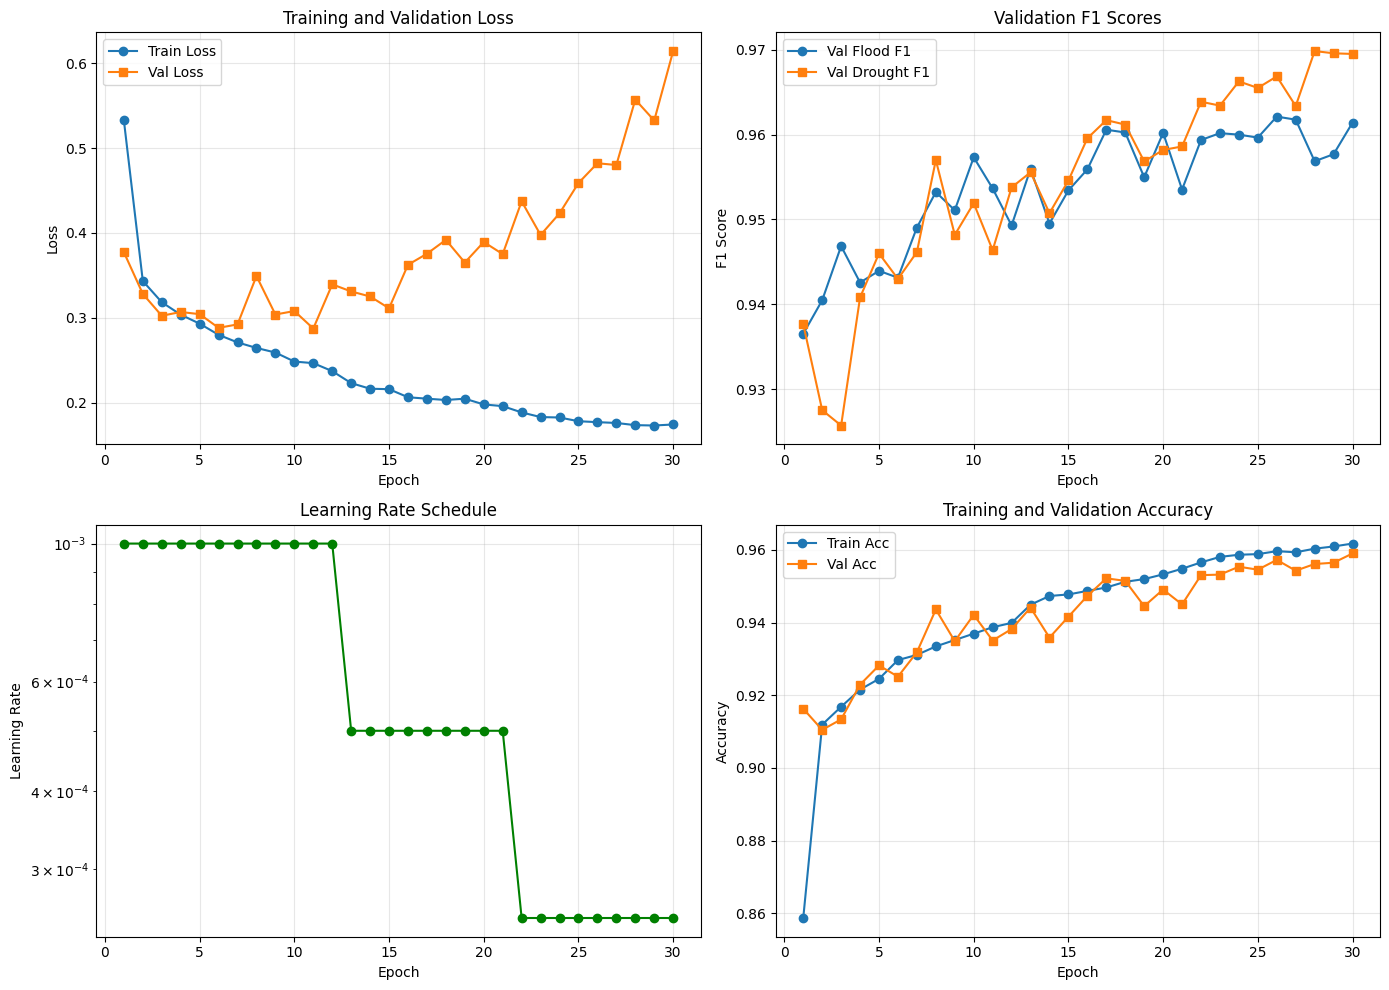

In [13]:
# Save training history
history_path = os.path.join(LOG_DIR, f"{config.experiment_name}_history.json")
history.save(history_path)

# Plot training curves
fig = history.plot(save_path=os.path.join(LOG_DIR, f"{config.experiment_name}_curves.png"))
plt.show()

## 10. Evaluate on Test Set

In [15]:
# Load best model - with error handling
best_model_path = os.path.join(MODEL_DIR, f"{config.experiment_name}_best.pt")

try:
    if os.path.exists(best_model_path):
        print(f"Loading best model from: {best_model_path}")
        checkpoint_manager.load(model, filepath=best_model_path)
        print("✅ Best model loaded successfully!")
    else:
        print("⚠️ No best model found, using current model weights")
except Exception as e:
    print(f"⚠️ Error loading checkpoint: {e}")
    print("Using current model weights for evaluation")

# Evaluate on test set
test_loss, test_metrics = validate_epoch(model, test_loader, criterion, device)

print("\n" + "="*60)
print("📊 TEST SET EVALUATION")
print("="*60)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"\n🌊 Flood Prediction:")
print(f"   Accuracy: {test_metrics.get('flood_accuracy', 0):.4f}")
print(f"   Precision: {test_metrics.get('flood_precision', 0):.4f}")
print(f"   Recall: {test_metrics.get('flood_recall', 0):.4f}")
print(f"   F1 Score: {test_metrics.get('flood_f1', 0):.4f}")
if 'flood_roc_auc' in test_metrics:
    print(f"   ROC-AUC: {test_metrics.get('flood_roc_auc', 0):.4f}")

print(f"\n🏜️ Drought Prediction:")
print(f"   Accuracy: {test_metrics.get('drought_accuracy', 0):.4f}")
print(f"   Precision: {test_metrics.get('drought_precision', 0):.4f}")
print(f"   Recall: {test_metrics.get('drought_recall', 0):.4f}")
print(f"   F1 Score: {test_metrics.get('drought_f1', 0):.4f}")
if 'drought_roc_auc' in test_metrics:
    print(f"   ROC-AUC: {test_metrics.get('drought_roc_auc', 0):.4f}")

print(f"\n📈 Average Metrics:")
print(f"   Accuracy: {test_metrics.get('avg_accuracy', 0):.4f}")
print(f"   F1 Score: {test_metrics.get('avg_f1', 0):.4f}")
print("="*60)

Loading best model from: /Users/leonnn/Desktop/DL for disaster/models/disaster_prediction_fast_best.pt
⚠️ Error loading checkpoint: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy.core.multiarray.scalar])` context manager to 

Validating:   0%|          | 0/382 [00:00<?, ?it/s]


📊 TEST SET EVALUATION

Test Loss: 0.7239

🌊 Flood Prediction:
   Accuracy: 0.9587
   Precision: 0.9751
   Recall: 0.9587
   F1 Score: 0.9638
   ROC-AUC: 0.9912

🏜️ Drought Prediction:
   Accuracy: 0.9407
   Precision: 0.9794
   Recall: 0.9407
   F1 Score: 0.9561
   ROC-AUC: 0.9554

📈 Average Metrics:
   Accuracy: 0.9497
   F1 Score: 0.9599


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]

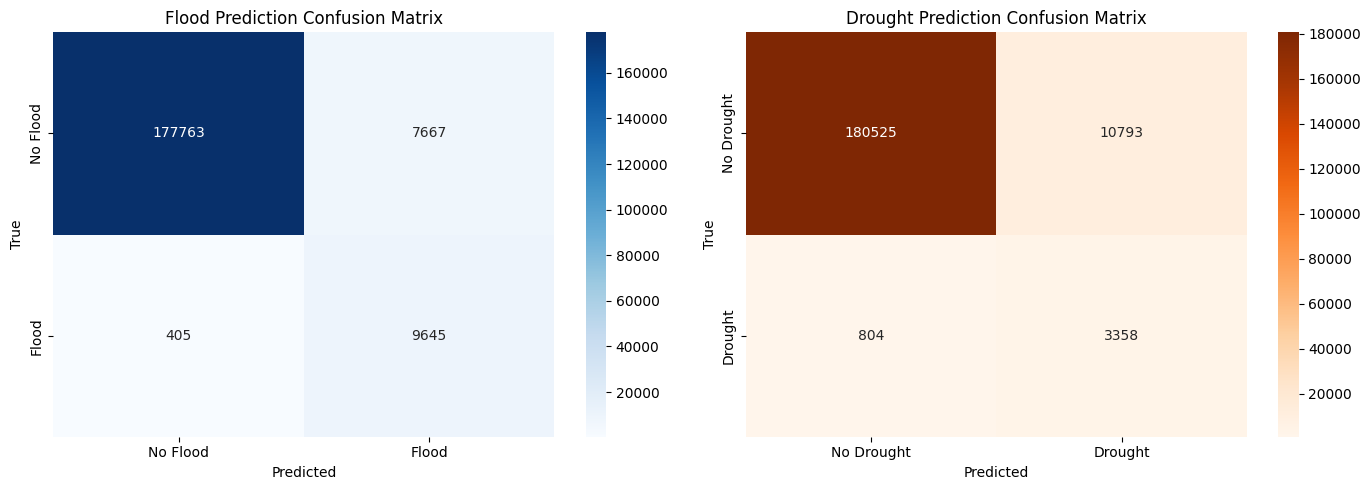

In [16]:
# Generate detailed evaluation metrics and confusion matrices
model.eval()
all_flood_preds, all_flood_labels = [], []
all_drought_preds, all_drought_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        satellite = batch['satellite'].to(device)
        weather = batch['weather'].to(device)
        static = batch['static'].to(device)
        
        outputs = model(satellite, weather, static)
        
        flood_preds = torch.argmax(outputs['flood_logits'], dim=1)
        drought_preds = torch.argmax(outputs['drought_logits'], dim=1)
        
        all_flood_preds.extend(flood_preds.cpu().numpy())
        all_flood_labels.extend(batch['flood_label'].numpy())
        all_drought_preds.extend(drought_preds.cpu().numpy())
        all_drought_labels.extend(batch['drought_label'].numpy())

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flood confusion matrix
from sklearn.metrics import confusion_matrix
cm_flood = confusion_matrix(all_flood_labels, all_flood_preds)
sns.heatmap(cm_flood, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'])
axes[0].set_title('Flood Prediction Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Drought confusion matrix
cm_drought = confusion_matrix(all_drought_labels, all_drought_preds)
sns.heatmap(cm_drought, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['No Drought', 'Drought'],
            yticklabels=['No Drought', 'Drought'])
axes[1].set_title('Drought Prediction Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, f"{config.experiment_name}_confusion_matrices.png"), dpi=150)
plt.show()

## 11. Save Final Results

In [17]:
import json

# Save final results
results = {
    "experiment_name": config.experiment_name,
    "model_config": {
        "encoder_output_dim": config.model.encoder_output_dim,
        "cnn_channels": config.model.cnn_channels,
        "lstm_hidden_size": config.model.lstm_hidden_size,
        "lstm_num_layers": config.model.lstm_num_layers
    },
    "training_config": {
        "num_epochs": config.training.num_epochs,
        "learning_rate": config.training.learning_rate,
        "batch_size": config.data.batch_size,
        "sequence_length": config.data.sequence_length
    },
    "best_epoch": early_stopping.best_epoch,
    "best_val_f1": best_val_f1,
    "test_metrics": {k: float(v) for k, v in test_metrics.items()},
    "total_training_time": total_time
}

results_path = os.path.join(LOG_DIR, f"{config.experiment_name}_results.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to {results_path}")
print(f"\n🎉 Training complete! Model saved to {MODEL_DIR}")


✅ Results saved to /Users/leonnn/Desktop/DL for disaster/logs/disaster_prediction_fast_results.json

🎉 Training complete! Model saved to /Users/leonnn/Desktop/DL for disaster/models


---
## Summary

This notebook trained a multi-encoder deep learning model for natural disaster prediction:

1. **CNN Encoder** processed satellite imagery features (NDVI, EVI, LST) to capture spatial patterns
2. **LSTM Encoder** processed weather sequences to capture temporal patterns
3. **MLP Encoder** processed static geographic features (elevation, landcover, coordinates)
4. **Mid-Level Fusion** combined all encoder outputs
5. **Dual Prediction Heads** made predictions for both flood and drought

The model was trained with:
- Class-weighted loss for handling imbalanced data
- Learning rate scheduling
- Early stopping
- Mixed precision training (when available)

Next steps:
- Run the evaluation notebook for detailed analysis
- Fine-tune hyperparameters if needed
- Deploy model for inference